### Table de contenu

- 1 [Numérisation et stockage des images en fichier CSV](#1)
- 2 [Pré-traitement des données](#2)
- 3 [Implémentation de l'encodeur et du décodeur](#3)
    - 3.1 [CNN](#3.1)
        - 3.1.1 [Calcul du taux de compression](#3.1.1)
        - 3.1.2 [Calcul de la qualité de compression](#3.1.2)
    - 3.2 [RNN](#3.2)

In [1]:
#necessary imports

from keras.preprocessing import image
from skimage import io,metrics
from tensorflow.keras.preprocessing.image import array_to_img
import csv
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.layers import Dense,Conv2D,MaxPooling2D,Conv2DTranspose,UpSampling2D,Flatten,Reshape,BatchNormalization
from sewar.full_ref import ssim
from keras.layers import Input, Dense
from keras.models import Model


# **1. Numérisation et stockage des images en BDD** <a class="anchor" id="1"></a>
Aulieu d'effectuer des directement manipulation sur les images, je préfere les stocker à la maniere de la BDD Mnist, dans un dataframe, ou chaque ligne represente une image et chaque colonne represente un pixel de l'image ainsi que son etiquette.

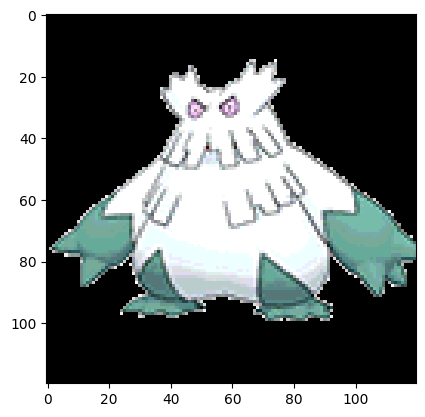

In [2]:
#Visualisation d'une image du fichier
img = cv2.imread('images/images/abomasnow.png') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img=np.array(img)
plt.imshow(img)

In [3]:
doc = "images/images/"
#liste DF pour stocker les vecteurs representants les images du fichier
DF=[]
#liste pour stocker les etiquettes reliées aux image de notre base
labels=[]

#Boucler dans les images du document
for images in os.listdir(doc):
    img = cv2.imread('images/images/'+images)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2=np.array(img)
    DF.append(img2)
    #[0:-4] pour enlever la partie ".png", ce qui nous donne un label pour chaque image
    labels.append(images[0:-4])

print("La liste des etiquettes :"+str(labels)+"\nLe nombre d'individus: "+str(len(labels)))

La liste des etiquettes :['abomasnow', 'abra', 'absol', 'accelgor', 'aegislash-blade', 'aerodactyl', 'aggron', 'aipom', 'alakazam', 'alomomola', 'altaria', 'amaura', 'ambipom', 'amoonguss', 'ampharos', 'anorith', 'araquanid', 'arbok', 'arcanine', 'arceus', 'archen', 'archeops', 'ariados', 'armaldo', 'aromatisse', 'aron', 'articuno', 'audino', 'aurorus', 'avalugg', 'axew', 'azelf', 'azumarill', 'azurill', 'bagon', 'baltoy', 'banette', 'barbaracle', 'barboach', 'basculin-red-striped', 'bastiodon', 'bayleef', 'beartic', 'beautifly', 'beedrill', 'beheeyem', 'beldum', 'bellossom', 'bellsprout', 'bergmite', 'bewear', 'bibarel', 'bidoof', 'binacle', 'bisharp', 'blacephalon', 'blastoise', 'blaziken', 'blissey', 'blitzle', 'boldore', 'bonsly', 'bouffalant', 'bounsweet', 'braixen', 'braviary', 'breloom', 'brionne', 'bronzong', 'bronzor', 'bruxish', 'budew', 'buizel', 'bulbasaur', 'buneary', 'bunnelby', 'burmy', 'butterfree', 'buzzwole', 'cacnea', 'cacturne', 'camerupt', 'carbink', 'carnivine', '

In [4]:
#Convertion des images en vecteur 1D
img3=np.concatenate(np.concatenate(DF[1]))
print("Pixels par image: "+str(len(img3)))

#Creation de la barre des colonnes (pixels et libellé)
first_row=[]
for i in range (len(img3)):
    first_row.append("pixel "+str(i))
first_row.append("label")

print("Barre horizontale: "+str(first_row))

Pixels par image: 43200
Barre horizontale: ['pixel 0', 'pixel 1', 'pixel 2', 'pixel 3', 'pixel 4', 'pixel 5', 'pixel 6', 'pixel 7', 'pixel 8', 'pixel 9', 'pixel 10', 'pixel 11', 'pixel 12', 'pixel 13', 'pixel 14', 'pixel 15', 'pixel 16', 'pixel 17', 'pixel 18', 'pixel 19', 'pixel 20', 'pixel 21', 'pixel 22', 'pixel 23', 'pixel 24', 'pixel 25', 'pixel 26', 'pixel 27', 'pixel 28', 'pixel 29', 'pixel 30', 'pixel 31', 'pixel 32', 'pixel 33', 'pixel 34', 'pixel 35', 'pixel 36', 'pixel 37', 'pixel 38', 'pixel 39', 'pixel 40', 'pixel 41', 'pixel 42', 'pixel 43', 'pixel 44', 'pixel 45', 'pixel 46', 'pixel 47', 'pixel 48', 'pixel 49', 'pixel 50', 'pixel 51', 'pixel 52', 'pixel 53', 'pixel 54', 'pixel 55', 'pixel 56', 'pixel 57', 'pixel 58', 'pixel 59', 'pixel 60', 'pixel 61', 'pixel 62', 'pixel 63', 'pixel 64', 'pixel 65', 'pixel 66', 'pixel 67', 'pixel 68', 'pixel 69', 'pixel 70', 'pixel 71', 'pixel 72', 'pixel 73', 'pixel 74', 'pixel 75', 'pixel 76', 'pixel 77', 'pixel 78', 'pixel 79', 'pixel

In [5]:
# Convertion de chaque image de la liste DF en ligne de "PokemonDF.csv"
with open('pokemon.csv', mode='a', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    
    # Ajout de la ligne "first_row" en premier
    writer.writerow(first_row)
    
    for i in DF: 
        #Convertir chaque array en vecteur
        img3=np.concatenate(np.concatenate(i))

        label = labels.pop(0) 
        # Une ligne sera composé de la partie pixels et la partie label
        row = list(img3) + [label]
        # on insert chaque "row" en tant que ligne dans notre fichier CSV
        writer.writerow(row)


# **2. Prétraitement des données** <a class="anchor" id="2"></a>

In [6]:
# On isole les étiquettes
data=pd.read_csv('pokemon.csv')
y=data['label']
a=list(data.columns)
a.pop(-1)
data=data[a]

abra


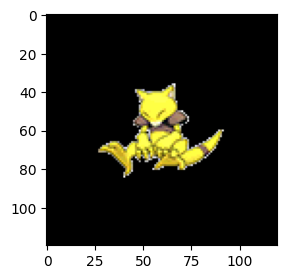

In [7]:
#Visualization d'une image de notre BDD + son libellé
new_image = np.asarray(data[1:2])
print(y[1])
new_image = new_image.reshape(120, 120, 3)
plt.figure(figsize=(8,3))
plt.imshow(new_image)

In [8]:
# on normalise les données avant de nourir le modele
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=0)
X_train.shape

(728, 43200)

In [9]:
#Redimensionnement (Vu qu'un modele CNN accepte les images multidimensionnelles en entrée)
#Le nom de la fonction indique son utilité
def vector_to_colored_image(df):
    size=len(df)
    df=np.array(df)
    return df.reshape((size,120,120,3))

In [10]:
#Redimensionnement
X_train=vector_to_colored_image(X_train)
X_test=vector_to_colored_image(X_test)

In [11]:
#Normalisation
X_train_norm=X_train.astype('float32') / 255.
X_test_norm = X_test.astype('float32') / 255.

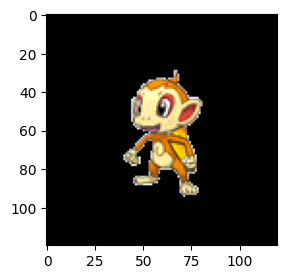

In [12]:
new_image = X_train_norm[1:2].reshape(120, 120, 3)
plt.figure(figsize=(8,3))
plt.imshow(new_image)

# **3. Implémentation de l'encodeur et du décodeur** <a class="anchor" id="3"></a>

## **3.1. CNN** <a class="anchor" id="3.1"></a>

In [13]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(120, 120, 3),name="input")
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)


code_layer = MaxPooling2D((2, 2),name="code")(x)

x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu',padding='same')(x) 
x = UpSampling2D((2, 2))(x)

output_layer = Conv2D(3, (3, 3), padding='same',name="output")(x)


In [14]:
pokemon_auto_encoder = Model(inputs=input_layer, outputs=output_layer)
pokemon_auto_encoder.compile(optimizer='adam', loss='mse')
pokemon_auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 code (MaxPooling2D)         (None, 30, 30, 16)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 16)       2320      
 nspose)                                                     

In [15]:
pokemon_auto_encoder.fit(X_train_norm, X_train_norm,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_norm, X_test_norm))

Epoch 1/30
23/23 [==============================] - 16s 644ms/step - loss: 0.0526 - val_loss: 0.0191
Epoch 2/30
23/23 [==============================] - 15s 640ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 3/30
23/23 [==============================] - 15s 636ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 4/30
23/23 [==============================] - 15s 640ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 5/30
23/23 [==============================] - 15s 635ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 6/30
23/23 [==============================] - 15s 640ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 7/30
23/23 [==============================] - 15s 637ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 8/30
23/23 [==============================] - 15s 637ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 9/30
23/23 [==============================] - 15s 638ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 10/30
23/23 [==============================] - 15s 636ms/step - loss: 0.0075 - val_lo

In [16]:
get_encoded_pokemon = Model(inputs=pokemon_auto_encoder.input, outputs=pokemon_auto_encoder.get_layer("code").output)

In [17]:
encoded_pokemon = get_encoded_pokemon.predict(X_test_norm)
encoded_pokemon.shape

3/3 [==============================] - 0s 32ms/step


(81, 30, 30, 16)

In [18]:
decoded_pokemons = pokemon_auto_encoder.predict(X_test_norm)

3/3 [==============================] - 0s 86ms/step


In [19]:
def afficher_pokemon(X, n=8, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


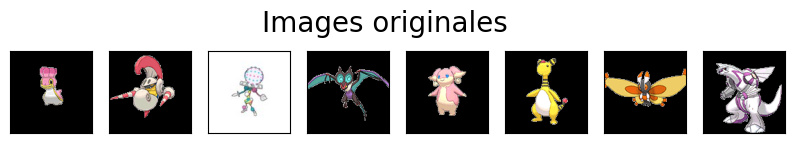

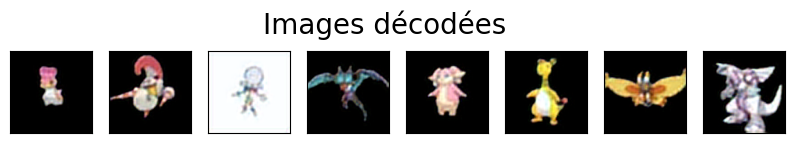

In [20]:
afficher_pokemon(X_test_norm, title="Images originales")
afficher_pokemon(decoded_pokemons, title="Images décodées")

### **3.1.1 Calcul du taux de compression** <a class="anchor" id="3.1.1"></a>

In [21]:
O=np.prod(X_test_norm.shape)
E=np.prod(encoded_pokemon.shape)
taux=1-(E/O)
print("Le taux de compression est "+str((taux*100))+"%")

Le taux de compression est 66.66666666666667%


**Remarque:** Ceci signifie que les images compréssées sont 0.67 fois plus petites que les images originales

### **3.1.2 Calcul de la qualité de compression** <a class="anchor" id="3.1.2"></a>
Pour calculer le qualité de compression on utilise **SSIM** (indice de similarité structurelle), qui sera calculé entre chaque image originale et sa version compréssée, puis on calcule la moyenne pour toutes les images de la base de données de Test.

In [22]:
decoded_pokemons.shape

(81, 120, 120, 3)

In [23]:
qual_compression=[]

for i in range(len(X_test_norm)):
    img1=X_test_norm[i:i+1]
    img1=np.asarray(img1)
    img1=np.squeeze(img1)
    
    img2=decoded_pokemons[i:i+1]
    img2=np.asarray(img2)
    img2=np.squeeze(img2)

    # a = la valeur de similarité structurale
    ssim=metrics.structural_similarity(img1, img2,channel_axis=2,win_size=3,data_range=1)
    qual_compression.append(ssim)
    
print("La moyenne des valeurs de similarité structurale est: "+str(np.mean(qual_compression)))



La moyenne des valeurs de similarité structurale est: 0.79189444


## **3.2. RNN** <a class="anchor" id="3.2"></a>

In [24]:
tf.compat.v1.reset_default_graph()

input_img = Input(shape=(120,120,3))
encoded = Dense(128, name='e1', activation='relu')(input_img)
encoded = Dense(64, name='e2', activation='relu')(encoded)
encoded = Dense(32, name='e3', activation='relu')(encoded)

decoded = Dense(64, name='d1', activation='relu')(encoded)
decoded = Dense(128, name='d2', activation='relu')(decoded)
decoded = Dense(3, name='d3', activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 e1 (Dense)                  (None, 120, 120, 128)     512       
                                                                 
 e2 (Dense)                  (None, 120, 120, 64)      8256      
                                                                 
 e3 (Dense)                  (None, 120, 120, 32)      2080      
                                                                 
 d1 (Dense)                  (None, 120, 120, 64)      2112      
                                                                 
 d2 (Dense)                  (None, 120, 120, 128)     8320      
                                                                 
 d3 (Dense)                  (None, 120, 120, 3)       387   

In [25]:
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 e1 (Dense)                  (None, 120, 120, 128)     512       
                                                                 
 e2 (Dense)                  (None, 120, 120, 64)      8256      
                                                                 
 e3 (Dense)                  (None, 120, 120, 32)      2080      
                                                                 
Total params: 10,848
Trainable params: 10,848
Non-trainable params: 0
_________________________________________________________________


In [26]:
encoded_input = Input(shape=(120,120,32))
decoder_layer = autoencoder.get_layer('d1')(encoded_input)
decoder_layer = autoencoder.get_layer('d2')(decoder_layer)
decoder_layer = autoencoder.get_layer('d3')(decoder_layer)
decoder = Model(encoded_input, decoder_layer)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 32)]    0         
                                                                 
 d1 (Dense)                  (None, 120, 120, 64)      2112      
                                                                 
 d2 (Dense)                  (None, 120, 120, 128)     8320      
                                                                 
 d3 (Dense)                  (None, 120, 120, 3)       387       
                                                                 
Total params: 10,819
Trainable params: 10,819
Non-trainable params: 0
_________________________________________________________________


In [27]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [28]:
X_test.shape

(81, 120, 120, 3)

In [29]:
autoencoder.fit(X_train_norm, X_train_norm,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_norm, X_test_norm))


Epoch 1/5
3/3 [==============================] - 35s 10s/step - loss: 0.6924 - val_loss: 0.6878
Epoch 2/5
3/3 [==============================] - 27s 9s/step - loss: 0.6858 - val_loss: 0.6810
Epoch 3/5
3/3 [==============================] - 26s 9s/step - loss: 0.6785 - val_loss: 0.6727
Epoch 4/5
3/3 [==============================] - 25s 8s/step - loss: 0.6696 - val_loss: 0.6620
Epoch 5/5
3/3 [==============================] - 26s 8s/step - loss: 0.6581 - val_loss: 0.6485


In [30]:
encoded_imgs = encoder.predict(X_test_norm)
decoded_imgs = decoder.predict(encoded_imgs)

3/3 [==============================] - 1s 153ms/step


In [31]:
autoencoder.fit(X_train_norm, X_train_norm,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_norm, X_test_norm))
encoded_imgs = encoder.predict(X_test_norm)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/20
3/3 [==============================] - 31s 9s/step - loss: 0.6441 - val_loss: 0.6320
Epoch 2/20
3/3 [==============================] - 26s 8s/step - loss: 0.6266 - val_loss: 0.6131
Epoch 3/20
3/3 [==============================] - 28s 8s/step - loss: 0.6069 - val_loss: 0.5929
Epoch 4/20
3/3 [==============================] - 28s 9s/step - loss: 0.5869 - val_loss: 0.5730
Epoch 5/20
3/3 [==============================] - 30s 9s/step - loss: 0.5670 - val_loss: 0.5529
Epoch 6/20
3/3 [==============================] - 28s 9s/step - loss: 0.5461 - val_loss: 0.5279
Epoch 7/20
3/3 [==============================] - 29s 9s/step - loss: 0.5185 - val_loss: 0.4950
Epoch 8/20
3/3 [==============================] - 28s 9s/step - loss: 0.4838 - val_loss: 0.4556
Epoch 9/20
3/3 [==============================] - 27s 9s/step - loss: 0.4406 - val_loss: 0.4041
Epoch 10/20
3/3 [==============================] - 29s 9s/step - loss: 0.3861 - val_loss: 0.3435
Epoch 11/20
3/3 [======================

In [32]:
autoencoder.fit(X_train_norm, X_train_norm,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_norm, X_test_norm))
encoded_imgs = encoder.predict(X_test_norm)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/30
3/3 [==============================] - 28s 9s/step - loss: 0.0987 - val_loss: 0.0993
Epoch 2/30
3/3 [==============================] - 27s 9s/step - loss: 0.0978 - val_loss: 0.0984
Epoch 3/30
3/3 [==============================] - 25s 8s/step - loss: 0.0971 - val_loss: 0.0978
Epoch 4/30
3/3 [==============================] - 27s 8s/step - loss: 0.0966 - val_loss: 0.0973
Epoch 5/30
3/3 [==============================] - 26s 9s/step - loss: 0.0961 - val_loss: 0.0968
Epoch 6/30
3/3 [==============================] - 26s 9s/step - loss: 0.0955 - val_loss: 0.0964
Epoch 7/30
3/3 [==============================] - 27s 9s/step - loss: 0.0951 - val_loss: 0.0957
Epoch 8/30
3/3 [==============================] - 26s 9s/step - loss: 0.0945 - val_loss: 0.0953
Epoch 9/30
3/3 [==============================] - 24s 8s/step - loss: 0.0941 - val_loss: 0.0952
Epoch 10/30
3/3 [==============================] - 25s 8s/step - loss: 0.0939 - val_loss: 0.0947
Epoch 11/30
3/3 [======================

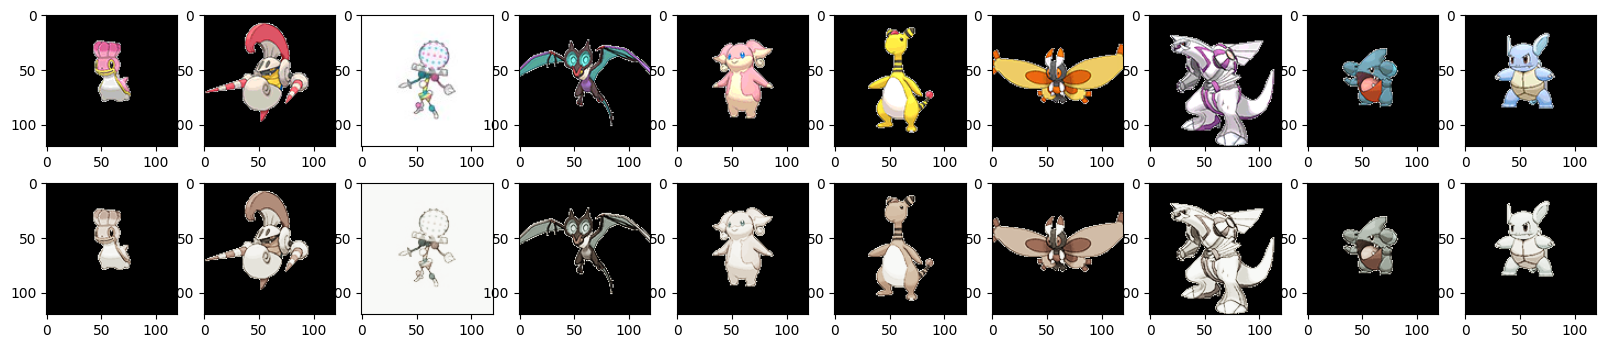

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    for indice2, col in enumerate(row):
        if indice == 0:
            col.imshow(X_test[indice2].reshape(120,120,3))
        else:
            col.imshow(decoded_imgs[indice2].reshape(120,120,3))

plt.show()